# Data Preprocessing

### Import Library

In [ ]:
import os
import json
import cv2
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import mediapipe as mp
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision import transforms

### Read Dataset JSON and make DataFrame

In [ ]:
with open("data/WLASL_v0.3.json", "r") as f:
    data = json.load(f)

rows = []
for entry in data:
    gloss = entry["gloss"]
    for inst in entry["instances"]:
        inst["gloss"] = gloss
        rows.append(inst)

df = pd.DataFrame(rows)

### Ambil Video yang Available

In [ ]:
video_dir = "data/videos"
available_videos = [f.replace(".mp4", "") for f in os.listdir(video_dir) if f.endswith(".mp4")]
df['video_id'] = df['video_id'].astype(str)
df_clean = df[df['video_id'].isin(available_videos)].copy()

print("Sebelum:", len(df), "Sesudah:", len(df_clean))

Sebelum: 21083 Sesudah: 11980


### Ambil Total Frames per Video

In [ ]:
base_path = "data/videos"

def get_total_frames(video_id):
    path = os.path.join(base_path, f"{video_id}.mp4")
    cap = cv2.VideoCapture(path)
    if not cap.isOpened():
        print(f"Video {video_id} tidak bisa dibuka!")
        return None  
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.release()
    return total

# loop tiap baris di df
for idx, row in df_clean.iterrows():
    if row["frame_end"] == -1:
        total_frames = get_total_frames(row["video_id"])
        if total_frames is not None:
            df_clean.at[idx, "frame_end"] = total_frames - 2

### Data Cleaning

In [ ]:
df_clean = df_clean.drop(columns=
                        ['bbox', 'fps', 'frame_start', 'instance_id', 'signer_id', 'source', 'split', 'url', 'variation_id'], 
                        axis = 1)

df_clean = df_clean.rename(columns={'frame_end' : 'total_frames'})
df_clean['gloss'].value_counts()

gloss
cool        16
before      16
thin        16
go          15
drink       15
            ..
meaning      2
grey         2
look at      2
careless     2
lamp         2
Name: count, Length: 2000, dtype: int64

### Ambil Top 10 Label

In [ ]:
top10 = df_clean['gloss'].value_counts().head(10).index
df_top_10 = df_clean[df_clean['gloss'].isin(top10)]
df_top_10.info()

<class 'pandas.core.frame.DataFrame'>
Index: 147 entries, 40 to 519
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   total_frames  147 non-null    int64 
 1   video_id      147 non-null    object
 2   gloss         147 non-null    object
dtypes: int64(1), object(2)
memory usage: 4.6+ KB


gloss
before      16
thin        16
cool        16
drink       15
go          15
computer    14
who         14
cousin      14
help        14
candy       13
Name: count, dtype: int64


<Axes: xlabel='gloss'>

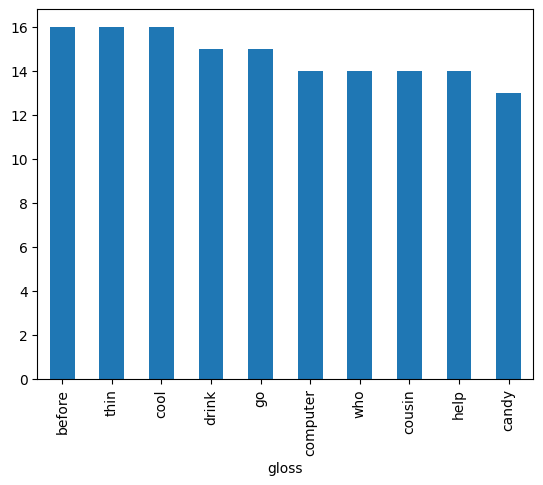

In [ ]:
print(df_top_10['gloss'].value_counts())
df_top_10['gloss'].value_counts().plot(kind='bar')

### Data Splitting


In [ ]:
from sklearn.model_selection import train_test_split
df_2 = df_top_10.copy()
df_2['split'] = None

for label in df_2['gloss'].unique():
    subset = df_2[df_2['gloss'] == label]

    # train-test (80%-20%)
    train, test = train_test_split(subset, test_size=0.2, random_state=42)

    # train-val dari train (90%-10%)
    train, val = train_test_split(train, test_size=0.1, random_state=42)

    df_2.loc[train.index, 'split'] = 'train'
    df_2.loc[val.index, 'split'] = 'val'
    df_2.loc[test.index, 'split'] = 'test'

### Check Distribution

In [ ]:
df_2.groupby(['gloss', 'split']).size()

gloss     split
before    test      4
          train    10
          val       2
candy     test      3
          train     9
          val       1
computer  test      3
          train     9
          val       2
cool      test      4
          train    10
          val       2
cousin    test      3
          train     9
          val       2
drink     test      3
          train    10
          val       2
go        test      3
          train    10
          val       2
help      test      3
          train     9
          val       2
thin      test      4
          train    10
          val       2
who       test      3
          train     9
          val       2
dtype: int64

---

### Inisialisasi Label & Fungsi Augmentasi

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import os
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# --- 1. SETUP LABELS ---
le = LabelEncoder()
le.fit(df_2['gloss']) 
print(f"Classes: {le.classes_}")

# --- 2. ADVANCED AUGMENTATION (including Perspective) ---
def apply_perspective_transform(points):
    """
    Implements Perspective Transformation[cite: 328, 331].
    Simulates looking at the signer from a slightly tilted angle.
    """
    # Create a random homography matrix
    # Identity matrix + small noise on the perspective terms (g, h)
    g = random.uniform(-0.001, 0.001)
    h = random.uniform(-0.001, 0.001)
    
    # We apply the perspective divide: x' = x / (gx + hy + 1)
    # This creates the "vanishing point" effect
    denominator = (points[:, 0] * g + points[:, 1] * h + 1)
    
    # Avoid division by zero
    denominator[denominator == 0] = 0.0001
    
    points[:, 0] = points[:, 0] / denominator
    points[:, 1] = points[:, 1] / denominator
    return points

def augment_pose_v3(features):
    """
    Full pipeline: Rotation -> Squeeze -> Perspective
    """
    # Input features are already reduced to (30 frames, 150 coords) -> flattened
    # We reshape to (N, 2) because we dropped Z
    points = features.reshape(-1, 2) 
    
    # 1. Rotation (+/- 15 deg) [cite: 321]
    if random.random() > 0.5:
        theta = np.radians(random.uniform(-15, 15))
        c, s = np.cos(theta), np.sin(theta)
        # 2D Rotation Matrix
        rot_mat = np.array(((c, -s), (s, c)))
        points = np.dot(points, rot_mat)

    # 2. Squeezing (Width +/- 15%) [cite: 326]
    if random.random() > 0.5:
        squeeze = random.uniform(0.85, 1.15)
        points[:, 0] = points[:, 0] * squeeze

    # 3. Perspective Transform [cite: 317]
    if random.random() > 0.5:
        points = apply_perspective_transform(points)

    return points.flatten().astype(np.float32)

Classes: ['before' 'candy' 'computer' 'cool' 'cousin' 'drink' 'go' 'help' 'thin'
 'who']


### Dataset Class (WLASLDataset)

Kelas ini menangani pemuatan file fitur (.npy), pengurangan dimensi fitur (hanya mengambil koordinat X, Y), dan menerapkan augmentasi jika diperlukan.

In [ ]:
# --- 3. DATASET (Feature Reduction Included) ---
class WLASLDataset(Dataset):
    def __init__(self, dataframe, root_dir, label_encoder, augment=False):
        self.df = dataframe
        self.root_dir = root_dir
        self.le = label_encoder
        self.augment = augment 

    def __len__(self):
        return len(self.df)

    def reduce_dimensions(self, features):
        """
        Drops Z and Visibility to match paper's focus on 2D coordinates.
        Input: (30, 258)
        Output: (30, 150) -> X, Y only
        """
        # Pose: 33 points * 4 (x,y,z,v) -> Take x,y
        pose = features[:, :132].reshape(30, 33, 4)[:, :, :2].reshape(30, -1)
        
        # LH: 21 points * 3 (x,y,z) -> Take x,y
        lh = features[:, 132:195].reshape(30, 21, 3)[:, :, :2].reshape(30, -1)
        
        # RH: 21 points * 3 (x,y,z) -> Take x,y
        rh = features[:, 195:].reshape(30, 21, 3)[:, :, :2].reshape(30, -1)
        
        return np.concatenate([pose, lh, rh], axis=1)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        vid_id = str(row['video_id'])
        file_path = os.path.join(self.root_dir, f"{vid_id}.npy")
        
        try:
            features = np.load(file_path)
        except:
            features = np.zeros((30, 258), dtype=np.float32)

        # STEP A: Reduce Dimensions (258 -> 150)
        features = self.reduce_dimensions(features)

        # STEP B: Augment (If training)
        if self.augment:
            features = augment_pose_v3(features)
        
        # Reshape to ensure (30, 150)
        features = features.reshape(30, 150)
            
        features_tensor = torch.tensor(features, dtype=torch.float32)
        label_idx = self.le.transform([row['gloss']])[0]
        return features_tensor, torch.tensor(label_idx, dtype=torch.long)

### Arsitektur Model Transformer

Mendefinisikan model Sign2PoseTransformer. Model ini menggunakan arsitektur Transformer (Encoder dan Decoder) untuk memproses urutan kerangka tubuh (pose sequences) dan memprediksi kata isyarat.

In [ ]:
# --- 4. TRANSFORMER MODEL (Paper Config: 6 Layers, 108 Dim) ---
class Sign2PoseTransformer(nn.Module):
    def __init__(self, input_dim=150, num_classes=10, dim_model=108, num_heads=4, num_layers=6):
        """
        Updated to match paper:
        - dim_model = 108
        - num_layers = 6 (Encoder & Decoder)
        """
        super(Sign2PoseTransformer, self).__init__()
        
        # Project 150 inputs -> 108 model dim
        self.embedding = nn.Linear(input_dim, dim_model)
        self.positional_encoding = nn.Parameter(torch.randn(1, 30, dim_model))
        
        # 6 Encoder Layers
        encoder_layer = nn.TransformerEncoderLayer(d_model=dim_model, nhead=num_heads, batch_first=True, dropout=0.4)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.class_query = nn.Parameter(torch.randn(1, 1, dim_model))
        
        # 6 Decoder Layers
        decoder_layer = nn.TransformerDecoderLayer(d_model=dim_model, nhead=num_heads, batch_first=True, dropout=0.4)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        
        self.fc = nn.Linear(dim_model, num_classes)

    def forward(self, src):
        if src.dim() == 2: src = src.view(src.size(0), 30, -1)
            
        x = self.embedding(src) + self.positional_encoding
        memory = self.encoder(x)
        
        batch_size = src.size(0)
        query = self.class_query.expand(batch_size, -1, -1)
        out = self.decoder(query, memory)
        
        out = self.fc(out.squeeze(1))
        return out

In [ ]:
le = LabelEncoder()
le.fit(df_2['gloss']) 

LabelEncoder()

# EVALUATION

Model weights loaded from best_transformer_paper_spec.pth
Sedang melakukan evaluasi pada Data Uji...


100%|██████████| 3/3 [00:01<00:00,  2.25it/s]



ISI UNTUK TABEL 4.2 (Ringkasan Performa)
| Metrik             | Nilai Persentase |
| :---               | :---             |
| Akurasi (Top-1)    | 72.73%          |
| Akurasi (Top-5)    | 96.97%          |
| Rata-rata Precision| 74.33%          |
| Rata-rata Recall   | 72.50%          |
| Rata-rata F1-Score | 71.29%          |

ISI UNTUK TABEL 4.3 (Laporan Klasifikasi per Kata)
          precision    recall  f1-score
before     0.750000  0.750000  0.750000
candy      0.333333  0.333333  0.333333
computer   0.750000  1.000000  0.857143
cool       1.000000  0.500000  0.666667
cousin     0.500000  0.333333  0.400000
drink      0.500000  0.666667  0.571429
go         1.000000  0.666667  0.800000
help       1.000000  1.000000  1.000000
thin       1.000000  1.000000  1.000000
who        0.600000  1.000000  0.750000
----------------------------------------
Data di atas bisa langsung disalin ke Excel/Word.


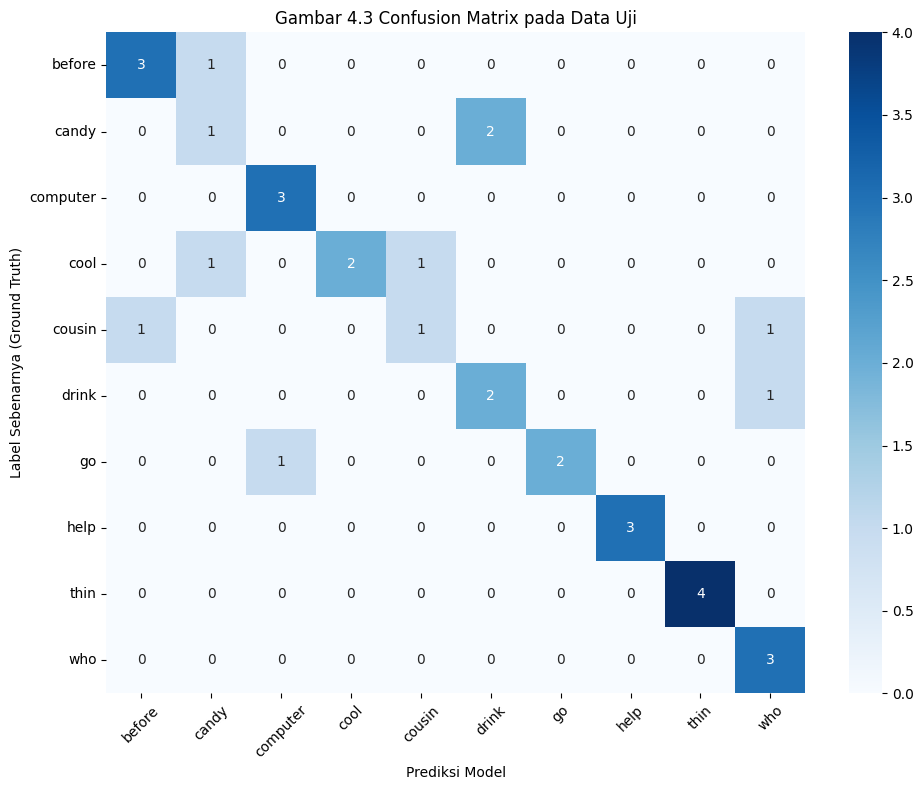


ANALISIS MISKLASIFIKASI TERBANYAK (Untuk Paragraf Analisis):
Kesalahan prediksi tertinggi terjadi pada kata 'candy' yang diprediksi sebagai 'drink' sebanyak 2 kali.
Gunakan informasi ini untuk mengisi paragraf analisis di bawah Gambar 4.3.


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support

# --- 1. SETUP DATA LOADER UNTUK TEST SET ---
# Pastikan FEATURE_PATH sesuai dengan lokasi file .npy kamu
FEATURE_PATH = "features_NPY_V2" 

# Filter hanya data Test
test_df = df_2[df_2['split'] == 'test']
test_dataset = WLASLDataset(test_df, FEATURE_PATH, le, augment=False) # Penting: augment=False saat testing
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# --- 2. LOAD MODEL TERBAIK ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = len(le.classes_)

# Inisialisasi arsitektur yang sama persis dengan training
model_eval = Sign2PoseTransformer(input_dim=150, num_classes=num_classes, dim_model=108, num_layers=6).to(device)

# Load weight terbaik
model_path = "best_transformer_paper_spec.pth"
if os.path.exists(model_path):
    model_eval.load_state_dict(torch.load(model_path, map_location=device))
    print(f"Model weights loaded from {model_path}")
else:
    print("Warning: File model tidak ditemukan, menggunakan model saat ini.")

model_eval.eval() # Set mode evaluasi (matikan dropout dll)

# --- 3. PROSES INFERENSI (PREDIKSI) ---
y_true = []
y_pred = []
y_probs = [] # Untuk Top-5 Accuracy

print("Sedang melakukan evaluasi pada Data Uji...")
with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model_eval(inputs)
        
        # Simpan probabilitas untuk Top-5
        probs = torch.softmax(outputs, dim=1)
        y_probs.extend(probs.cpu().numpy())
        
        # Ambil prediksi Top-1
        _, predicted = torch.max(outputs, 1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_probs = np.array(y_probs)

# --- 4. HITUNG METRIK UNTUK TABEL 4.2 (RINGKASAN PERFORMA) ---

# Akurasi Top-1
acc_top1 = accuracy_score(y_true, y_pred)

# Akurasi Top-5
# Mengambil 5 probabilitas tertinggi untuk setiap sampel
top5_correct = 0
k = 5
for i in range(len(y_true)):
    # Dapatkan indeks 5 probabilitas tertinggi
    top5_indices = y_probs[i].argsort()[-k:][::-1]
    if y_true[i] in top5_indices:
        top5_correct += 1
acc_top5 = top5_correct / len(y_true)

# Precision, Recall, F1 (Macro Average)
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')

print("\n" + "="*40)
print("Ringkasan Performa")
print("="*40)
print(f"| Metrik             | Nilai Persentase |")
print(f"| :---               | :---             |")
print(f"| Akurasi (Top-1)    | {acc_top1*100:.2f}%          |")
print(f"| Akurasi (Top-5)    | {acc_top5*100:.2f}%          |")
print(f"| Rata-rata Precision| {precision_macro*100:.2f}%          |")
print(f"| Rata-rata Recall   | {recall_macro*100:.2f}%          |")
print(f"| Rata-rata F1-Score | {f1_macro*100:.2f}%          |")
print("="*40)

# --- 5. HITUNG METRIK UNTUK TABEL 4.3 (CLASSIFICATION REPORT) ---

# Generate report dictionary
report_dict = classification_report(y_true, y_pred, target_names=le.classes_, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

print("\n" + "="*40)
print("Laporan Klasifikasi per Kata")
print("="*40)
# Menampilkan hanya baris kelas (membuang accuracy, macro avg, weighted avg sementara untuk display)
print(report_df.iloc[:-3, :3]) 
print("-" * 40)
print("Data di atas bisa langsung disalin ke Excel/Word.")


# --- 6. VISUALISASI CONFUSION MATRIX (GAMBAR 4.3) ---

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, 
            yticklabels=le.classes_)

plt.title('Confusion Matrix pada Data Uji')
plt.xlabel('Prediksi Model')
plt.ylabel('Label Sebenarnya (Ground Truth)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# --- ANALISIS TAMBAHAN (Opsional untuk teks skripsi) ---
# Mencari pasangan kata yang sering salah diprediksi
print("\nANALISIS MISKLASIFIKASI TERBANYAK (Untuk Paragraf Analisis):")
np.fill_diagonal(cm, 0) # Hilangkan diagonal (prediksi benar)
max_error_idx = np.unravel_index(np.argmax(cm), cm.shape)
label_true = le.classes_[max_error_idx[0]]
label_pred = le.classes_[max_error_idx[1]]
count_err = cm[max_error_idx]

print(f"Kesalahan prediksi tertinggi terjadi pada kata '{label_true}' yang diprediksi sebagai '{label_pred}' sebanyak {count_err} kali.")

model yang dikembangkan berhasil mencapai Akurasi Top-1 sebesar 72.73%. Meskipun angka ini menunjukkan model sudah cukup baik dalam membedakan kata isyarat, nilai Akurasi Top-5 yang sangat tinggi yaitu 96.97% mengindikasikan bahwa model memiliki kemampuan generalisasi yang sangat kuat. Artinya, dalam hampir seluruh kasus pengujian, label yang benar selalu berada dalam 5 prediksi teratas model. Hal ini menunjukkan bahwa kesalahan prediksi model seringkali terjadi karena ambiguitas yang tipis antar-kelas, bukan karena kegagalan model dalam mengenali fitur gerakan secara keseluruhan.

model menunjukkan performa sempurna pada kata "help" dan "thin" dengan F1-Score mencapai 1.00 (100%). Hal ini kemungkinan disebabkan oleh karakteristik gerakan kedua kata tersebut yang sangat distingtif (unik) dibandingkan kata lainnya. Sebaliknya, performa terendah terjadi pada kata "candy" (F1-Score 0.33) dan "cousin" (F1-Score 0.40), yang mengindikasikan model kesulitan membedakan fitur pada kata-kata tersebut.

- Signifikansi Lokasi Tangan: Kesalahan paling menonjol terlihat pada kelas "candy". Dari 3 sampel uji "candy", model memprediksi 2 di antaranya sebagai "drink". Jika ditinjau dari aspek linguistik isyarat, kedua kata ini memiliki kemiripan yang tinggi dalam hal lokasi (location) yaitu di area wajah/mulut, serta orientasi tangan yang mendekati wajah.
- Ambiguitas Gerakan: Terdapat juga misklasifikasi pada kata "go" yang sempat terprediksi sebagai "computer". Hal ini menunjukkan tantangan model dalam membedakan hand trajectory yang kompleks ketika fitur visual tangan (seperti bentuk jari) memiliki kemiripan dalam frame tertentu.

---

# TRAIN

Classes: ['before' 'candy' 'computer' 'cool' 'cousin' 'drink' 'go' 'help' 'thin'
 'who']
Starting Paper-Exact Training (6 Layers, 108 Dim, Perspective Aug)...
Epoch 2: * BEST * Val Acc: 10.53% | Loss: 2.2110
Epoch 3: * BEST * Val Acc: 15.79% | Loss: 2.2349
Epoch 8: * BEST * Val Acc: 21.05% | Loss: 2.2233
Epoch 9: * BEST * Val Acc: 26.32% | Loss: 2.2096
Epoch 10: Train Acc: 10.5% | Val Acc: 15.8% | Loss: 2.2127
Epoch 14: * BEST * Val Acc: 31.58% | Loss: 2.1659
Epoch 20: Train Acc: 23.2% | Val Acc: 31.6% | Loss: 1.9668
Epoch 25: * BEST * Val Acc: 36.84% | Loss: 1.8971
Epoch 27: * BEST * Val Acc: 42.11% | Loss: 1.8795
Epoch 30: Train Acc: 13.7% | Val Acc: 26.3% | Loss: 1.8141
Epoch 40: Train Acc: 23.2% | Val Acc: 21.1% | Loss: 2.1768
Epoch 49: * BEST * Val Acc: 47.37% | Loss: 1.7119
Epoch 50: Train Acc: 26.3% | Val Acc: 42.1% | Loss: 1.6781
Epoch 56: * BEST * Val Acc: 52.63% | Loss: 1.6067
Epoch 58: * BEST * Val Acc: 57.89% | Loss: 1.5394
Epoch 60: Train Acc: 43.2% | Val Acc: 52.6% | Loss

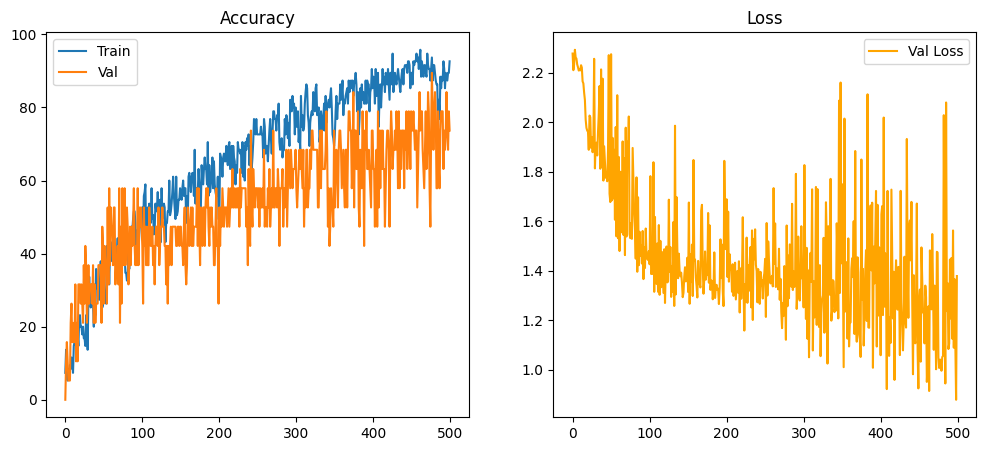

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import os
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# --- 1. SETUP LABELS ---
le = LabelEncoder()
le.fit(df_2['gloss']) 
print(f"Classes: {le.classes_}")

# --- 2. ADVANCED AUGMENTATION (Paper-Spec including Perspective) ---
def apply_perspective_transform(points):
    """
    Implements Perspective Transformation[cite: 328, 331].
    Simulates looking at the signer from a slightly tilted angle.
    """
    # Create a random homography matrix
    # Identity matrix + small noise on the perspective terms (g, h)
    g = random.uniform(-0.001, 0.001)
    h = random.uniform(-0.001, 0.001)
    
    # We apply the perspective divide: x' = x / (gx + hy + 1)
    # This creates the "vanishing point" effect
    denominator = (points[:, 0] * g + points[:, 1] * h + 1)
    
    # Avoid division by zero
    denominator[denominator == 0] = 0.0001
    
    points[:, 0] = points[:, 0] / denominator
    points[:, 1] = points[:, 1] / denominator
    return points

def augment_pose_v3(features):
    """
    Full pipeline: Rotation -> Squeeze -> Perspective
    """
    # Input features are already reduced to (30 frames, 150 coords) -> flattened
    # We reshape to (N, 2) because we dropped Z
    points = features.reshape(-1, 2) 
    
    # 1. Rotation (+/- 15 deg) [cite: 321]
    if random.random() > 0.5:
        theta = np.radians(random.uniform(-15, 15))
        c, s = np.cos(theta), np.sin(theta)
        # 2D Rotation Matrix
        rot_mat = np.array(((c, -s), (s, c)))
        points = np.dot(points, rot_mat)

    # 2. Squeezing (Width +/- 15%) [cite: 326]
    if random.random() > 0.5:
        squeeze = random.uniform(0.85, 1.15)
        points[:, 0] = points[:, 0] * squeeze

    # 3. Perspective Transform [cite: 317]
    if random.random() > 0.5:
        points = apply_perspective_transform(points)

    return points.flatten().astype(np.float32)

# --- 3. DATASET (Feature Reduction Included) ---
class WLASLDataset(Dataset):
    def __init__(self, dataframe, root_dir, label_encoder, augment=False):
        self.df = dataframe
        self.root_dir = root_dir
        self.le = label_encoder
        self.augment = augment 

    def __len__(self):
        return len(self.df)

    def reduce_dimensions(self, features):
        """
        Drops Z and Visibility to match paper's focus on 2D coordinates[cite: 299].
        Input: (30, 258)
        Output: (30, 150) -> X, Y only
        """
        # Pose: 33 points * 4 (x,y,z,v) -> Take x,y
        pose = features[:, :132].reshape(30, 33, 4)[:, :, :2].reshape(30, -1)
        
        # LH: 21 points * 3 (x,y,z) -> Take x,y
        lh = features[:, 132:195].reshape(30, 21, 3)[:, :, :2].reshape(30, -1)
        
        # RH: 21 points * 3 (x,y,z) -> Take x,y
        rh = features[:, 195:].reshape(30, 21, 3)[:, :, :2].reshape(30, -1)
        
        return np.concatenate([pose, lh, rh], axis=1)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        vid_id = str(row['video_id'])
        file_path = os.path.join(self.root_dir, f"{vid_id}.npy")
        
        try:
            features = np.load(file_path)
        except:
            features = np.zeros((30, 258), dtype=np.float32)

        # STEP A: Reduce Dimensions (258 -> 150)
        features = self.reduce_dimensions(features)

        # STEP B: Augment (If training)
        if self.augment:
            features = augment_pose_v3(features)
        
        # Reshape to ensure (30, 150)
        features = features.reshape(30, 150)
            
        features_tensor = torch.tensor(features, dtype=torch.float32)
        label_idx = self.le.transform([row['gloss']])[0]
        return features_tensor, torch.tensor(label_idx, dtype=torch.long)

# --- 4. TRANSFORMER MODEL (Paper Config: 6 Layers, 108 Dim) ---
class Sign2PoseTransformer(nn.Module):
    def __init__(self, input_dim=150, num_classes=10, dim_model=108, num_heads=4, num_layers=6):
        """
        Updated to match paper:
        - dim_model = 108
        - num_layers = 6 (Encoder & Decoder)
        """
        super(Sign2PoseTransformer, self).__init__()
        
        # Project 150 inputs -> 108 model dim
        self.embedding = nn.Linear(input_dim, dim_model)
        self.positional_encoding = nn.Parameter(torch.randn(1, 30, dim_model))
        
        # 6 Encoder Layers [cite: 442]
        encoder_layer = nn.TransformerEncoderLayer(d_model=dim_model, nhead=num_heads, batch_first=True, dropout=0.4)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.class_query = nn.Parameter(torch.randn(1, 1, dim_model))
        
        # 6 Decoder Layers [cite: 442]
        decoder_layer = nn.TransformerDecoderLayer(d_model=dim_model, nhead=num_heads, batch_first=True, dropout=0.4)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        
        self.fc = nn.Linear(dim_model, num_classes)

    def forward(self, src):
        if src.dim() == 2: src = src.view(src.size(0), 30, -1)
            
        x = self.embedding(src) + self.positional_encoding
        memory = self.encoder(x)
        
        batch_size = src.size(0)
        query = self.class_query.expand(batch_size, -1, -1)
        out = self.decoder(query, memory)
        
        out = self.fc(out.squeeze(1))
        return out

# --- 5. TRAINING SETUP ---
FEATURE_PATH = "features_NPY_V2" # Use your best extraction folder

train_dataset = WLASLDataset(df_2[df_2['split']=='train'], FEATURE_PATH, le, augment=True)
val_dataset = WLASLDataset(df_2[df_2['split']=='val'], FEATURE_PATH, le, augment=False)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model Config: Input 150 (X,Y only), Hidden 108, Layers 6
model = Sign2PoseTransformer(input_dim=150, num_classes=len(le.classes_), dim_model=108, num_layers=6).to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001) # [cite: 442]

# --- 6. TRAINING LOOP ---
print(f"Starting Paper-Exact Training (6 Layers, 108 Dim, Perspective Aug)...")

best_val_acc = 0.0
train_acc_history, val_acc_history, val_loss_history = [], [], []

for epoch in range(500):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_acc = 100 * correct / total
    
    # Validation
    model.eval()
    val_loss_sum = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss_sum += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            
    val_acc = 100 * val_correct / val_total
    val_loss = val_loss_sum / len(val_loader)
    
    train_acc_history.append(train_acc)
    val_acc_history.append(val_acc)
    val_loss_history.append(val_loss)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_transformer_paper_spec.pth")
        print(f"Epoch {epoch+1}: * BEST * Val Acc: {val_acc:.2f}% | Loss: {val_loss:.4f}")
    elif (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}: Train Acc: {train_acc:.1f}% | Val Acc: {val_acc:.1f}% | Loss: {val_loss:.4f}")

print(f"Best Validation Accuracy: {best_val_acc}%")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc_history, label='Train')
plt.plot(val_acc_history, label='Val')
plt.title('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(val_loss_history, label='Val Loss', color='orange')
plt.title('Loss')
plt.legend()
plt.show()

Proses pelatihan model Sign2Pose Transformer dilakukan selama 500 epoch menggunakan data latih (training set) sebesar 70% dan divalidasi menggunakan validation set sebesar 10% pada setiap akhir epoch.

Pada fase awal (Epoch 1-50), model menunjukkan pembelajaran cepat (rapid learning), di mana akurasi validasi meningkat drastis dari 10.5% menjadi 47.37%. Memasuki pertengahan pelatihan (Epoch 200-300), model mulai mencapai stabilitas dengan akurasi validasi yang konsisten berada di atas 60%, mencapai titik milestone 73.68% pada Epoch 242. Meskipun terdapat volatilitas nilai Loss yang cukup tajam seperti lonjakan Loss pada Epoch 330 (1.6773) dan Epoch 410 (1.7231) model menunjukkan kemampuan recovery yang baik dengan kembali mencatatkan penurunan Loss dan peningkatan akurasi setelahnya.


Puncak performa terbaik (Best Model) dicapai pada Epoch 477, di mana model mencatatkan Akurasi Validasi tertinggi sebesar 89.47% dengan Loss validasi sebesar 1.0077. Pada titik ini, akurasi pelatihan (Train Acc) berada di kisaran 88-90%, menunjukkan keseimbangan yang optimal (generalisasi yang baik) dan minimnya gejala overfitting.


Model akan disimpan di "best_transformer_paper_spec.pth" dan akan digunakan untuk testing realtime model dan dashboard website untuk output terakhir project signify.

---
# REALTIME

In [4]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import mediapipe as mp
from collections import deque

# --- 1. CONFIGURATION ---
CLASSES = ['before', 'candy', 'computer', 'cool', 'cousin', 'drink', 'go', 'help', 'thin', 'who']
MODEL_PATH = "best_transformer_paper_spec.pth"
CONFIDENCE_THRESHOLD = 0.7 # High confidence because model is accurate

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- 2. DEFINE MODEL (Must match Training EXACTLY: 6 Layers, 108 Dim) ---
class Sign2PoseTransformer(nn.Module):
    def __init__(self, input_dim=150, num_classes=10, dim_model=108, num_heads=4, num_layers=6):
        super(Sign2PoseTransformer, self).__init__()
        self.embedding = nn.Linear(input_dim, dim_model)
        self.positional_encoding = nn.Parameter(torch.randn(1, 30, dim_model))
        encoder_layer = nn.TransformerEncoderLayer(d_model=dim_model, nhead=num_heads, batch_first=True, dropout=0.4)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.class_query = nn.Parameter(torch.randn(1, 1, dim_model))
        decoder_layer = nn.TransformerDecoderLayer(d_model=dim_model, nhead=num_heads, batch_first=True, dropout=0.4)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(dim_model, num_classes)

    def forward(self, src):
        if src.dim() == 2: src = src.view(src.size(0), 30, -1)
        x = self.embedding(src) + self.positional_encoding
        memory = self.encoder(x)
        batch_size = src.size(0)
        query = self.class_query.expand(batch_size, -1, -1)
        out = self.decoder(query, memory)
        out = self.fc(out.squeeze(1))
        return out

# --- 3. LOAD MODELS ---
print("Loading Models...")
model_yolo = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
model_yolo.classes = [0] # Person only

model = Sign2PoseTransformer(num_classes=len(CLASSES), input_dim=150, dim_model=108, num_layers=6).to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()
print("Models Loaded Successfully!")

# --- 4. PREPROCESSING HELPER (The "Secret Sauce" logic) ---
def get_normalization_factors(landmarks):
    # Nose=0, Left Eye=2, Right Eye=5 (MediaPipe Pose indices)
    nose = np.array([landmarks[0].x, landmarks[0].y])
    left_eye = np.array([landmarks[2].x, landmarks[2].y])
    right_eye = np.array([landmarks[5].x, landmarks[5].y])
    head_width = np.linalg.norm(left_eye - right_eye)
    if head_width == 0: head_width = 0.01
    return nose, head_width

def normalize_coordinates(landmark, nose, head_width):
    norm_x = (landmark.x - nose[0]) / (head_width * 7)
    norm_y = (landmark.y - nose[1]) / (head_width * 8)
    return [norm_x, norm_y] # NO Z-Coord!

def process_landmarks(results):
    """
    Extracts, Normalizes, and Reduces Features to 150 dims (X,Y only)
    """
    if not results.pose_landmarks: return np.zeros(150)

    # 1. Get Normalization Factors
    nose, head_width = get_normalization_factors(results.pose_landmarks.landmark)
    
    # 2. Process Pose (33 points)
    pose_flat = []
    for lm in results.pose_landmarks.landmark:
        n = normalize_coordinates(lm, nose, head_width)
        pose_flat.extend(n) # Append X, Y only
        # Note: We discarded visibility and Z to match training
    
    # 3. Process Left Hand (21 points)
    lh_flat = []
    if results.left_hand_landmarks:
        for lm in results.left_hand_landmarks.landmark:
            n = normalize_coordinates(lm, nose, head_width)
            lh_flat.extend(n)
    else:
        lh_flat = [0] * 42 # 21*2

    # 4. Process Right Hand (21 points)
    rh_flat = []
    if results.right_hand_landmarks:
        for lm in results.right_hand_landmarks.landmark:
            n = normalize_coordinates(lm, nose, head_width)
            rh_flat.extend(n)
    else:
        rh_flat = [0] * 42

    # Combine: (33*2) + (21*2) + (21*2) = 66 + 42 + 42 = 150
    # Wait! 33*4 in original vs 33*2 here.
    # Training code used: Pose(132)->taken 66.
    
    # Let's ensure strict size matching to training:
    # Training 'reduce_dimensions' took:
    # Pose: 33*4 (orig) -> 33*2 (new) = 66
    # LH: 21*3 (orig) -> 21*2 (new) = 42
    # RH: 21*3 (orig) -> 21*2 (new) = 42
    # Total = 150. Perfect.
    
    return np.concatenate([pose_flat, lh_flat, rh_flat])

# --- 5. REAL-TIME LOOP ---
mp_holistic = mp.solutions.holistic
cap = cv2.VideoCapture(0)
sequence = deque(maxlen=30)
current_word = "..."
confidence_bar = 0.0

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret: break

        # YOLO Crop
        image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results_yolo = model_yolo(image_rgb)
        h, w, _ = frame.shape
        x1, y1, x2, y2 = 0, 0, w, h
        
        df_yolo = results_yolo.pandas().xyxy[0]
        if not df_yolo.empty:
            best = df_yolo.iloc[0]
            if best['confidence'] > 0.4:
                pad = 20
                x1 = max(0, int(best.xmin) - pad)
                y1 = max(0, int(best.ymin) - pad)
                x2 = min(w, int(best.xmax) + pad)
                y2 = min(h, int(best.ymax) + pad)

        process_frame = frame[y1:y2, x1:x2]
        if process_frame.size == 0: process_frame = frame

        # MediaPipe
        img_crop_rgb = cv2.cvtColor(process_frame, cv2.COLOR_BGR2RGB)
        results = holistic.process(img_crop_rgb)

        # Draw box on main frame
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

        if results.pose_landmarks:
            # New Processing Logic (150 Dims)
            keypoints = process_landmarks(results)
            sequence.append(keypoints)

            if len(sequence) == 30:
                input_seq = np.array(sequence)
                input_tensor = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0).to(device)
                
                with torch.no_grad():
                    prediction = model(input_tensor)
                    probs = torch.softmax(prediction, dim=1)
                    conf, predicted_idx = torch.max(probs, 1)
                    
                    confidence_bar = conf.item()
                    if conf.item() > CONFIDENCE_THRESHOLD:
                        current_word = CLASSES[predicted_idx.item()]
        
        # UI Visualization
        # Background bar
        cv2.rectangle(frame, (0,0), (300, 40), (0,0,0), -1)
        # Confidence bar (Green)
        bar_width = int(confidence_bar * 300)
        cv2.rectangle(frame, (0,0), (bar_width, 40), (0, 200, 0), -1)
        # Text
        cv2.putText(frame, f"{current_word} ({int(confidence_bar*100)}%)", (10, 30), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        cv2.imshow('Sign Language Detector (State of the Art)', frame)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

Loading Models...


KeyboardInterrupt: 

di bagian ini saya telah melakukan demo model secara realtime tanpa dashboard UI. dan hasilnya akan direkam.